In [1]:
import pandas as  pd
import numpy  as  np
import matplotlib.pyplot  as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import statsmodels.api as sm_api
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from scipy.stats.stats import pearsonr   
import scikit_posthocs as sp

In [2]:
df  = pd.read_csv(r'/home/silva/Downloads/lista_empregados2.csv')

In [3]:
df_perfil = df

#Ajusta código empregado
df_perfil['COD_EMPREGADO'] = df_perfil['COD_EMPREGADO'].apply(str)
df_perfil['COD_EMPREGADO'] = 'B' + df_perfil['COD_EMPREGADO']

#Filtra colunas
df_perfil = df_perfil[['COD_EMPREGADO', 'DATA_ADMISSAO', 'DATA_NASCIMENTO', 'NIVEL_FUNCAO', 'EST_CIVIL', 'SEXO', 'DEP_CRECHE_BABA']]

#modifica tipo coluna
df_perfil['DATA_NASCIMENTO'] = df_perfil['DATA_NASCIMENTO'].apply(pd.to_datetime)
df_perfil['DATA_ADMISSAO'] = df_perfil['DATA_ADMISSAO'].apply(pd.to_datetime)

#Calcular tempo/idade
ano_hoje = pd.datetime.today().year
df_perfil['TEMPO_EMPRESA'] = ano_hoje -  df_perfil['DATA_ADMISSAO'].dt.year 
df_perfil['IDADE'] = ano_hoje - df_perfil['DATA_NASCIMENTO'].dt.year
df_perfil['COD_USUARIO'] = df_perfil['COD_EMPREGADO']

/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

## Leitura Dataset cobertura

In [4]:
df_cobertura = pd.read_csv(r'/home/silva/Downloads/tcc/cobertura_individual.csv')
df_cobertura['CSS'] = df_cobertura['CSS'].str.upper()
df_cobertura['NOME_CLASSE'] = df_cobertura['NOME_CLASSE'].str.upper()
df_cobertura['DATA'] = df_cobertura['ULT_ATUALIZACAO'].apply(pd.to_datetime)

#Remover sistemas não interessantes para o estudo
df_cobertura = df_cobertura[~df_cobertura['CSS'].str.startswith('PXC')]

## Agrupamento Dataset

In [5]:
#Seleciona ultima cobertura da classe
df_cobertura_ajustada = df_cobertura.sort_values('DATA').groupby(['NOME_CLASSE', 'COD_USUARIO']).tail(1)
#cria percentual coberto
df_cobertura_ajustada['PORCENTAGEM_COBERTA'] = 100 * df_cobertura_ajustada['LINHAS_COBERTAS'] / (df_cobertura_ajustada['LINHAS_NAO_COBERTAS'] + df_cobertura_ajustada['LINHAS_COBERTAS'])
df_final = pd.merge(df_cobertura_ajustada, df_perfil, on='COD_USUARIO', how='inner')

----

## Funções

In [6]:
#Cria classe
def cria_classe(valor, media, classe_abaixo, classe_acima):
    if valor > media:
        return classe_acima
    return classe_abaixo

#Boxplot
def plot_boxplot(df_class, df_features_standardized, w, h, classe):
    df_standardized = pd.concat([df_class,df_features_standardized],axis=1)
    df_melted = pd.melt(df_standardized,
                    id_vars=classe,
                    var_name="features",
                    value_name='value')
    plt.figure(figsize=(w,h))
    sns.boxplot(x="features", y="value", hue=classe, data=df_melted)
    
def binning(col, method='doane'):
    hist, bin_edges = np.histogram(col, method)
    bined_values = np.digitize(col, bin_edges)
    bin_interval = list()
    for x in range(0, len(bin_edges)):
        if x == 0:
            bin_interval.append('(-Inf,{0})'.format(bin_edges[x]))
        elif x == (len(bin_edges) - 1):
            # bin_interval.append('({0},Inf)'.format(bin_edges[x]))
            continue
        else:
            bin_interval.append('({0},{1})'.format(bin_edges[x], bin_edges[x+1]))

    # Binning using cut function of pandas
    colBin = pd.cut(col, bins=bin_edges, labels=bin_interval, include_lowest=True)

    return colBin

def unstack_group(df, y, group):
    group.append(y)
    groupsizes = df.groupby(group).size()
    ctsum = groupsizes.unstack(y)
    return ctsum.fillna(0)

----

## Filtragens

mediana: 85.18518518518519
count    2534.000000
mean       69.797164
std        32.804781
min         0.000000
25%        58.887561
50%        81.496476
75%        94.444444
max       100.000000
Name: PORCENTAGEM_COBERTA, dtype: float64


/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0.98, 'Porcentagem de teste')

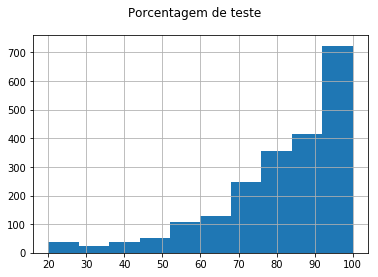

In [7]:
# Remove coberturas abaixo de 20%, pois de modo geral são classes apenas o construtor foi executado.
df_filtrada = df_final[df_final['PORCENTAGEM_COBERTA'] >= 20]
df_filtrada = df_filtrada[df_final['EST_CIVIL'] != 6]

#verifica
print("mediana: " + str(df_filtrada['PORCENTAGEM_COBERTA'].median()))
print(df_final['PORCENTAGEM_COBERTA'].describe())
df_filtrada['PORCENTAGEM_COBERTA'].hist()
plt.suptitle("Porcentagem de teste")

----

# Categorização

## Estado civil

In [9]:
def estado_civil(x):
    if x == 1:
        return "SOLTEIRO"
    elif x == 2:
        return "CASADO"
    else: return "DIVORCIADO"

df_filtrada['EST_CIVIL'] = df_filtrada['EST_CIVIL'].apply(lambda x : estado_civil(x))
df_filtrada['EST_CIVIL'] = df_filtrada['EST_CIVIL'].astype('category')

usuarios = df_filtrada.groupby('COD_USUARIO').tail(1)
usuarios['EST_CIVIL'] = usuarios['EST_CIVIL'].apply(lambda x : estado_civil(x))
usuarios['EST_CIVIL'] = usuarios['EST_CIVIL'].astype('category')


/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


## Idade

In [10]:
def cria_classe_idade(x):
    if x < 30:
        return '20 anos'
    elif x >= 30 and x <= 40:
        return '30 anos'
    elif x > 40:
        return 'acima 40 anos'
    

df_filtrada['FAIXA_ETARIA'] = df_filtrada.apply(lambda x: cria_classe_idade(x['IDADE']), axis=1)
df_filtrada['FAIXA_ETARIA'] = df_filtrada['FAIXA_ETARIA'].astype('category')

usuarios['FAIXA_ETARIA'] = usuarios.apply(lambda x: cria_classe_idade(x['IDADE']), axis=1)
usuarios['FAIXA_ETARIA'] = usuarios['FAIXA_ETARIA'].astype('category')
df_filtrada['BIN_IDADE'] = binning(df_filtrada['IDADE'])

/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Categorização ERRO - ALERTA - OK
<br>A empresa considera: <br>-OK: acima de 80%<br>-ALERTA: entre 79% e 70%<br>-ERRO: abaixo de 70%

In [11]:
def ocorrencia(x):
    if x >= 80:
        return 'OK'
    elif x<80 and x>=70:
        return 'ALERTA'
    else: 
        return 'ERRO'

OK        1318
ERRO       417
ALERTA     388
Name: TIPO_OCORRENCIA, dtype: int64


Text(0.5, 0.98, 'Tipo de ocorrência')

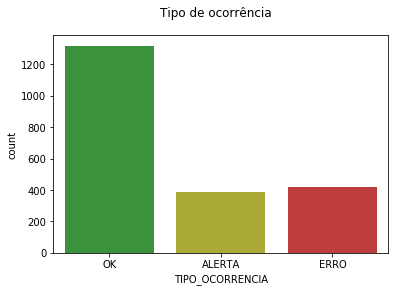

In [12]:
df_filtrada['TIPO_OCORRENCIA'] = df_filtrada.apply(lambda x: ocorrencia(x['PORCENTAGEM_COBERTA']), axis=1)
df_filtrada['TIPO_OCORRENCIA'] = df_filtrada['TIPO_OCORRENCIA'].astype('category')
df_filtrada['TIPO_OCORRENCIA'] = df_filtrada['TIPO_OCORRENCIA'].cat.reorder_categories(['OK', 'ALERTA', 'ERRO'])

print(df_filtrada['TIPO_OCORRENCIA'].value_counts())
sns.countplot(df_filtrada['TIPO_OCORRENCIA'],label="Count",  palette=["C2", "C8","C3"])
plt.suptitle("Tipo de ocorrência")

------

## 1) Verificações do objeto de estudo

### 1.1)Verifica usuários (únicos)

total de usuários únicos:155


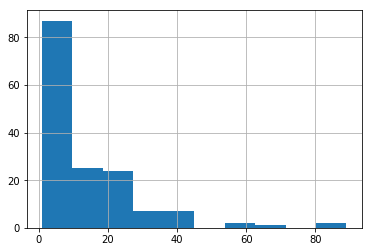

In [13]:
print("total de usuários únicos:" + str(len((df_filtrada['COD_USUARIO'].unique()))))
df_filtrada['COD_USUARIO'].value_counts().hist()

#### 1.1)A amostra é composta de um total de 155 desenvolvedores de software que produziram pelo menos uma evidência de cobertura de código em testes. 

### 1.2)Verificações de idade de usuários

Text(0.5, 0.98, 'Idade dos Desenvolvedores')

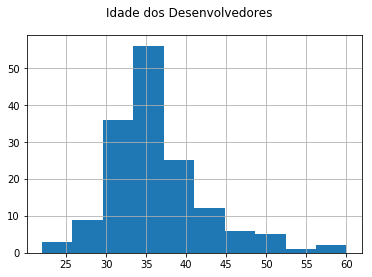

In [14]:
usuarios = df_filtrada.groupby('COD_USUARIO').tail(1)
#Verifica idade
usuarios['IDADE'].hist()
plt.suptitle("Idade dos Desenvolvedores")

In [15]:
print(usuarios['IDADE'].describe())
print(usuarios['IDADE'].median())

count    155.000000
mean      36.258065
std        6.012799
min       22.000000
25%       33.000000
50%       35.000000
75%       39.000000
max       60.000000
Name: IDADE, dtype: float64
35.0


30 anos          1718
acima 40 anos     240
20 anos           165
Name: FAIXA_ETARIA, dtype: int64


Text(0.5, 0.98, 'Faixa etária desenvolvedor que gerou ocorrência')

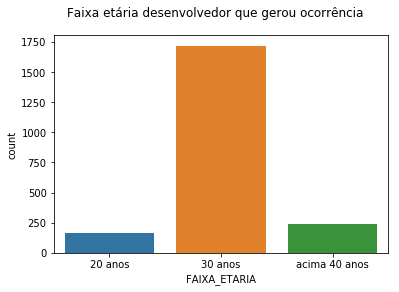

In [16]:
print(df_filtrada['FAIXA_ETARIA'].value_counts())
sns.countplot(df_filtrada['FAIXA_ETARIA'],label="Count")
plt.suptitle("Faixa etária desenvolvedor que gerou ocorrência")

#### 1.2) Maioria dos desenvolvedores, 75%, possuem entre 22 e 39 anos.  A faixa etária com mais representantes é a faixa de 30 anos de idade, sendo formada por 1718 indivíduos.

### 1.3)Sexo

In [17]:
usuarios['SEXO'].value_counts()

M    143
F     12
Name: SEXO, dtype: int64

#### 1.3)Maioria dos desenvolvedores são do sexo masculino, sendo apenas 12 do sexo feminino.

-----------

## 2) Correlacionando perfis com porcentagem

### 2.1) Variável SEXO

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


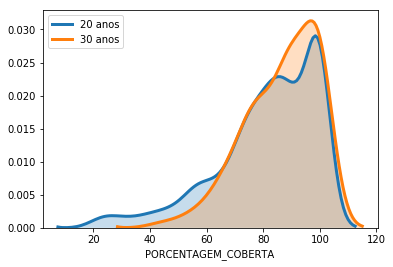

In [18]:
df_homens = df_filtrada[df_filtrada['SEXO'] == 'M']
df_mulheres = df_filtrada[df_filtrada['SEXO'] == 'F']

sns.distplot(df_homens['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '20 anos')
sns.distplot(df_mulheres['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '30 anos')

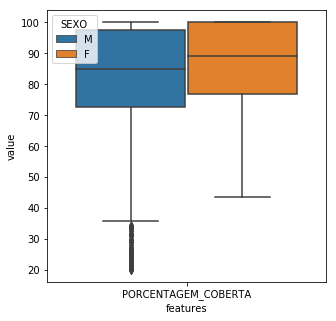

In [19]:
plot_boxplot(df_filtrada['SEXO'], df_filtrada['PORCENTAGEM_COBERTA'], 5, 5, 'SEXO')

### -> Verificando distribuições

In [20]:
print(stats.mannwhitneyu(df_homens['PORCENTAGEM_COBERTA'], df_mulheres['PORCENTAGEM_COBERTA']))

MannwhitneyuResult(statistic=123071.5, pvalue=0.002998664214452954)


In [21]:
df_sexo = unstack_group(df_filtrada, 'SEXO', ['TIPO_OCORRENCIA'])
df_sexo

SEXO,F,M
TIPO_OCORRENCIA,,
OK,101,1217
ALERTA,26,362
ERRO,17,400


In [22]:
chi2_contingency(df_sexo)

(6.449064962909699,
 0.039774372486844255,
 2,
 array([[  89.39802167, 1228.60197833],
        [  26.31747527,  361.68252473],
        [  28.28450306,  388.71549694]]))

### -> Verificação apenas das ocorrências em não conformidade com o ideal

In [23]:
df_homem_implantavel = df_homens[df_homens['TIPO_OCORRENCIA']!='OK']['PORCENTAGEM_COBERTA']
df_mulher_implantavel = df_mulheres[df_mulheres['TIPO_OCORRENCIA']!='OK']['PORCENTAGEM_COBERTA']

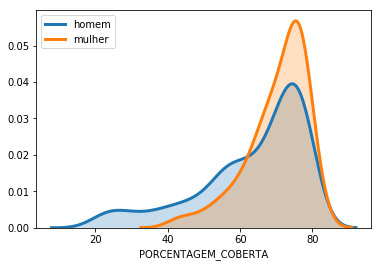

In [24]:
sns.distplot(df_homem_implantavel, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = 'homem')
sns.distplot(df_mulher_implantavel, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = 'mulher')

In [25]:
print(stats.mannwhitneyu(df_homem_implantavel, df_mulher_implantavel))

MannwhitneyuResult(statistic=12397.0, pvalue=0.003608320033174088)


In [26]:
def bin_ocorrencia(x):
    if x == 'OK':
        return 'OK'
    return 'NOK'

df_sexo = df_filtrada[['SEXO', 'TIPO_OCORRENCIA']]
df_sexo['TIPO_OCORRENCIA_BINARIA'] = df_sexo['TIPO_OCORRENCIA'].apply(lambda x: bin_ocorrencia(x))
df_sexo = unstack_group(df_sexo, 'SEXO', ['TIPO_OCORRENCIA_BINARIA'])

df_sexo

/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


SEXO,F,M
TIPO_OCORRENCIA_BINARIA,,
NOK,43,762
OK,101,1217


In [27]:
chi2_contingency(df_sexo)

(3.900597664258716,
 0.048268933367307476,
 1,
 array([[  54.60197833,  750.39802167],
        [  89.39802167, 1228.60197833]]))

#### temos indícios que a média de distribuição de porcentagem de código coberto, entre os sexos, é diferente. Pelo teste de Mann-whitney, ao nível de significância de 5%, verificamos que devemos rejeitar a hipótese de que a distribuição possui a mesma média. Pelo gráfico e pela tabela de contingência, reparamos que a o sexo feminino possui uma concentração maior em ocorrências do Tipo Ok, ou seja, com porcentagem de código acima de 80%. Quanto ao grupo masculino, há uma maior disperção dos dados, quando comparado ao grupo de amostras do sexo feminino.

#### Corroborando o algorimto apriori, que demonstra 15,7% (400) do total de amostras sejam relacionadas a homens que cometeram "erros" de cobertura de código (pela definição da empresa), existem evidências de diferença entre as médias entre homens e mulheres nessa faixa de cobertura (erro), o que leva a crer que o sexo masculino tem uma tendência maior a produzir coberturas com porcentagens menores. 

-----

### 2.2) Variável IDADE

In [28]:
df_20 = df_filtrada[df_filtrada['FAIXA_ETARIA'] == '20 anos']
df_30 = df_filtrada[df_filtrada['FAIXA_ETARIA'] == '30 anos']
df_40 = df_filtrada[df_filtrada['FAIXA_ETARIA'] == 'acima 40 anos']

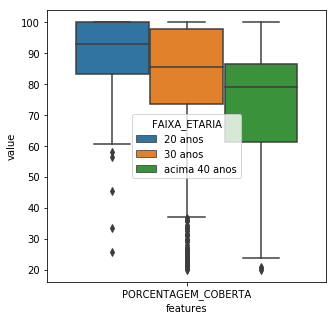

In [29]:
plot_boxplot(df_filtrada['FAIXA_ETARIA'], df_filtrada['PORCENTAGEM_COBERTA'], 5, 5, 'FAIXA_ETARIA')

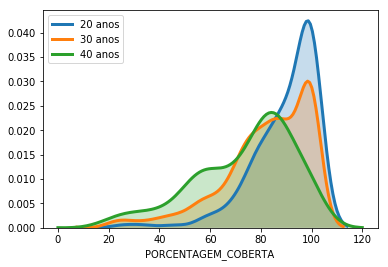

In [30]:
sns.distplot(df_20['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '20 anos')
sns.distplot(df_30['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '30 anos')
sns.distplot(df_40['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '40 anos')

In [31]:
print(stats.kruskal(df_20['PORCENTAGEM_COBERTA'], df_30['PORCENTAGEM_COBERTA'], df_40['PORCENTAGEM_COBERTA']))

KruskalResult(statistic=88.29236422112848, pvalue=6.722900942903351e-20)


In [32]:
sp.posthoc_dunn(df_filtrada, val_col='PORCENTAGEM_COBERTA', group_col='FAIXA_ETARIA', p_adjust = 'holm')

,20 anos,30 anos,acima 40 anos
20 anos,-1.000000e+00,1.376883e-08,6.811854e-20
30 anos,1.376883e-08,-1.000000e+00,1.381302e-11
acima 40 anos,6.811854e-20,1.381302e-11,-1.000000e+00


#### -> Verificando os desenvolvedores do sexo masculino

In [73]:
ph_sexo_m = sp.posthoc_dunn(df_filtrada[df_filtrada['SEXO']=='M'], val_col='PORCENTAGEM_COBERTA', group_col='FAIXA_ETARIA', p_adjust = 'holm')
ph_sexo_m

,20 anos,30 anos,acima 40 anos
20 anos,-1.000000e+00,7.112333e-09,1.981251e-19
30 anos,7.112333e-09,-1.000000e+00,1.322839e-10
acima 40 anos,1.981251e-19,1.322839e-10,-1.000000e+00


(<matplotlib.axes._subplots.AxesSubplot at 0x7f56bd1c3240>,
 <matplotlib.colorbar.ColorbarBase at 0x7f56bd11ecf8>)

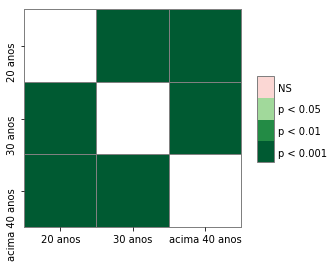

In [74]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(ph_sexo_m, **heatmap_args)

#### -> Verificando os desenvolvedores do sexo feminino

In [77]:
ph_sexo_f = sp.posthoc_dunn(df_filtrada[df_filtrada['SEXO']=='F'], val_col='PORCENTAGEM_COBERTA', group_col='FAIXA_ETARIA', p_adjust = 'holm')
ph_sexo_f

,20 anos,30 anos,acima 40 anos
20 anos,-1.000000,0.704307,0.372877
30 anos,0.704307,-1.000000,0.356289
acima 40 anos,0.372877,0.356289,-1.000000


(<matplotlib.axes._subplots.AxesSubplot at 0x7f56bd140550>,
 <matplotlib.colorbar.ColorbarBase at 0x7f56bd11bc50>)

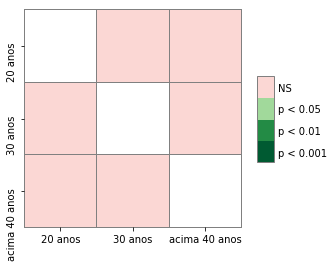

In [78]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(ph_sexo_f, **heatmap_args)

#### Pelo teste de Kruskal wallis, rejeita-se a hipótese nula, pois há indícies que a média das distribuições são diferentes, quando se leva em conta a faixa etaria. Há indícios de diferença significativa. Utilizando um teste pos-hoc de Dunn para comparações entre pares mostram que podemos rejeitar a hipótese nula (p <0,05) para cada par de faixas etárias e concluir que todos os grupos (faixas etárias) diferem em suas porcentagens cobertas. Porém, quando filtramos os grupos por sexo, verificamos que os grupos masculinos diferem entre si, fato que não ocorre entre os grupos feminos.

## 2.3) Variável FUNÇÃO

In [38]:
df_filtrada['NIVEL_FUNCAO'] = df_filtrada.NIVEL_FUNCAO.astype('category')
df_filtrada['NIVEL_FUNCAO'] = df_filtrada['NIVEL_FUNCAO'].cat.reorder_categories(['0', 'H0', 'G0', 'F0', 'E0', 'D0'])
df_filtrada['NIVEL_FUNCAO_COD'] =  df_filtrada['NIVEL_FUNCAO'].cat.codes + 1

In [39]:
df_filtrada[['NIVEL_FUNCAO_COD', 'PORCENTAGEM_COBERTA']].corr().iloc[0] 

NIVEL_FUNCAO_COD       1.000000
PORCENTAGEM_COBERTA   -0.181711
Name: NIVEL_FUNCAO_COD, dtype: float64

2    1147
4     516
1     292
5     133
6      20
3      15
Name: NIVEL_FUNCAO_COD, dtype: int64

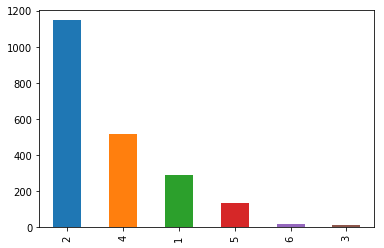

In [55]:
df_filtrada['NIVEL_FUNCAO_COD'].value_counts().plot.bar()
df_filtrada['NIVEL_FUNCAO_COD'].value_counts()
#print(stats.kruskal(df_20['PORCENTAGEM_COBERTA'], df_30['PORCENTAGEM_COBERTA'], df_40['PORCENTAGEM_COBERTA']))

In [56]:
df1 = df_filtrada[df_filtrada['NIVEL_FUNCAO_COD']==1]['PORCENTAGEM_COBERTA']
df2 = df_filtrada[df_filtrada['NIVEL_FUNCAO_COD']==2]['PORCENTAGEM_COBERTA']
df3 = df_filtrada[df_filtrada['NIVEL_FUNCAO_COD']==3]['PORCENTAGEM_COBERTA']
df4 = df_filtrada[df_filtrada['NIVEL_FUNCAO_COD']==4]['PORCENTAGEM_COBERTA']
df5 = df_filtrada[df_filtrada['NIVEL_FUNCAO_COD']==5]['PORCENTAGEM_COBERTA']
df6 = df_filtrada[df_filtrada['NIVEL_FUNCAO_COD']==6]['PORCENTAGEM_COBERTA']

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


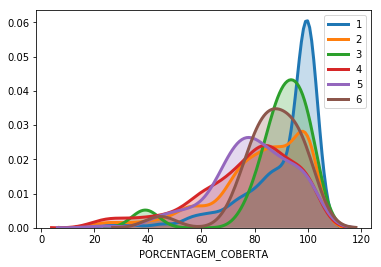

In [79]:
sns.distplot(df1, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '1')
sns.distplot(df2, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '2')
sns.distplot(df3, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '3')
sns.distplot(df4, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '4')
sns.distplot(df5, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '5')
sns.distplot(df6, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '6')

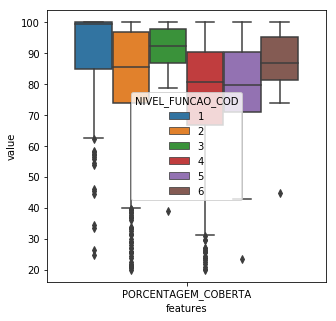

In [81]:
plot_boxplot(df_filtrada['NIVEL_FUNCAO_COD'], df_filtrada['PORCENTAGEM_COBERTA'], 5, 5, 'NIVEL_FUNCAO_COD')

In [58]:
print(stats.kruskal(df1,df2,df3,df4,df5))

KruskalResult(statistic=165.91393574334603, pvalue=7.875957490815196e-35)


In [70]:
ph = sp.posthoc_dunn(df_filtrada, val_col='PORCENTAGEM_COBERTA', group_col='NIVEL_FUNCAO_COD', p_adjust = 'holm')
ph

,1,2,3,4,5,6
1,-1.000000e+00,4.108756e-19,1.000000,2.529043e-34,2.224520e-15,0.436773
2,4.108756e-19,-1.000000e+00,0.451414,9.167261e-08,4.913748e-02,1.000000
3,1.000000e+00,4.514135e-01,-1.000000,4.814034e-02,9.362248e-02,1.000000
4,2.529043e-34,9.167261e-08,0.048140,-1.000000e+00,1.000000e+00,0.281797
5,2.224520e-15,4.913748e-02,0.093622,1.000000e+00,-1.000000e+00,0.436773
6,4.367728e-01,1.000000e+00,1.000000,2.817970e-01,4.367728e-01,-1.000000


(<matplotlib.axes._subplots.AxesSubplot at 0x7f56bd271908>,
 <matplotlib.colorbar.ColorbarBase at 0x7f56bd19d940>)

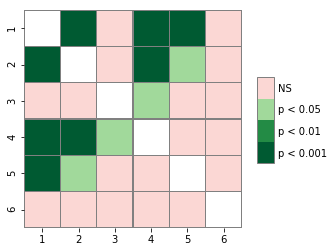

In [71]:
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(ph, **heatmap_args)

In [64]:
df_funcao = df_filtrada[['NIVEL_FUNCAO_COD', 'TIPO_OCORRENCIA']]
df_funcao = unstack_group(df_funcao, 'NIVEL_FUNCAO_COD', ['TIPO_OCORRENCIA'])
df_funcao

NIVEL_FUNCAO_COD,1,2,3,4,5,6
TIPO_OCORRENCIA,,,,,,
OK,238,717,13,269,66,15
ALERTA,28,220,1,97,38,4
ERRO,26,210,1,150,29,1


In [82]:
chi2_contingency(df_funcao)

(98.14708136302691,
 1.2791464497450827e-16,
 10,
 array([[181.27932171, 712.08007537,   9.31229392, 320.34291098,
          82.56900612,  12.4163919 ],
        [ 53.36599152, 209.62600094,   2.74140367,  94.30428639,
          24.30711258,   3.6552049 ],
        [ 57.35468676, 225.29392369,   2.9463024 , 101.35280264,
          26.1238813 ,   3.9284032 ]]))

In [84]:
print(df1.median())
print(df2.median())
print(df3.median())
print(df4.median())
print(df5.median())
print(df6.median())


99.48979591836735
85.46637744034707
92.3076923076923
80.718954248366
79.60526315789474
86.87505660719137


### Verificando o dataset, foi percebido que há diferença entre as diferentes funções dentro da empresa. É importante notar que dentro da empresa, as funções mais altas tendem a receber o código já com cobertura alta, pois de modo geral não há envolvimento no processo de codificação, o que se traduz em baixas amostragens e altos níveis de porcentagem de cobertura.

## 2.4) Variável TEMPO EMPRESA

/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


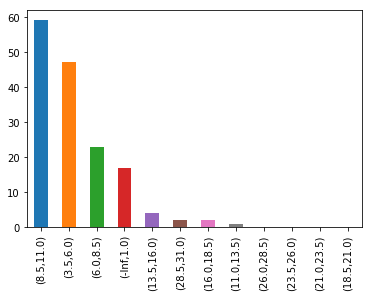

In [86]:
df_filtrada['BIN_TEMPO_EMPRESA'] = binning(df_filtrada['TEMPO_EMPRESA'])
usuarios['BIN_TEMPO_EMPRESA'] = binning(usuarios['TEMPO_EMPRESA'])
usuarios['BIN_TEMPO_EMPRESA'].value_counts().plot.bar()

In [92]:
labels_tempoempresa = usuarios['BIN_TEMPO_EMPRESA'].unique()

In [93]:
dfs = {}
for tempo_empresa in labels_tempoempresa:
    dfs[tempo_empresa] = df_filtrada[df_filtrada['BIN_TEMPO_EMPRESA']==tempo_empresa]['PORCENTAGEM_COBERTA']

In [95]:
df_temp_empresa = df_filtrada[['BIN_TEMPO_EMPRESA', 'TIPO_OCORRENCIA']]
df_temp_empresa = unstack_group(df_temp_empresa, 'BIN_TEMPO_EMPRESA', ['TIPO_OCORRENCIA'])
df_temp_empresa

BIN_TEMPO_EMPRESA,"(-Inf,1.0)","(2.764705882352941,4.529411764705882)","(4.529411764705882,6.294117647058823)","(6.294117647058823,8.058823529411764)","(8.058823529411764,9.823529411764707)","(9.823529411764707,11.588235294117647)","(13.352941176470587,15.117647058823529)","(15.117647058823529,16.88235294117647)","(16.88235294117647,18.647058823529413)","(29.235294117647058,31.0)","(11.588235294117647,13.352941176470587)"
TIPO_OCORRENCIA,,,,,,,,,,,
OK,204.0,108.0,358.0,135.0,155.0,312.0,2.0,22.0,10.0,12.0,0.0
ALERTA,17.0,46.0,116.0,42.0,49.0,100.0,1.0,13.0,3.0,1.0,0.0
ERRO,13.0,68.0,90.0,70.0,59.0,99.0,0.0,11.0,4.0,1.0,2.0


In [96]:
chi2_contingency(df_temp_empresa)

(120.48848236172441,
 2.3151719845951274e-16,
 20,
 array([[145.27178521, 137.82195007, 350.14225153, 153.34243994,
         163.27555346, 317.238813  ,   1.86245878,  28.55770137,
          10.55393311,   8.69147433,   1.24163919],
        [ 42.76589732,  40.57277438, 103.07677814,  45.1417805 ,
          48.06594442,  93.39048516,   0.54828073,   8.40697127,
           3.10692416,   2.55864343,   0.36552049],
        [ 45.96231748,  43.60527555, 110.78097033,  48.51577956,
          51.65850212, 100.37070184,   0.58926048,   9.03532737,
           3.33914272,   2.74988224,   0.39284032]]))

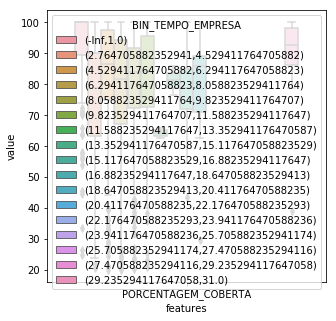

In [98]:

plot_boxplot(df_filtrada['BIN_TEMPO_EMPRESA'], df_filtrada['PORCENTAGEM_COBERTA'], 5, 5, 'BIN_TEMPO_EMPRESA')

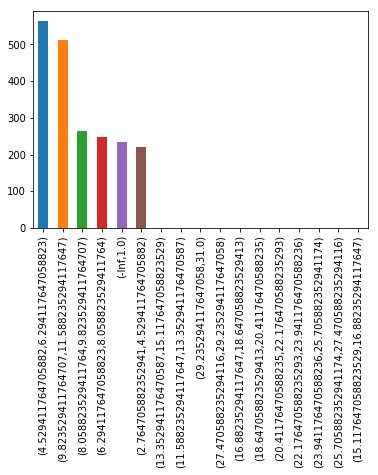

In [128]:
counts = df_filtrada['BIN_TEMPO_EMPRESA'].value_counts()
filtro_tempo = counts[counts> 200]
df_tempo_filtrado = df_filtrada[df_filtrada['BIN_TEMPO_EMPRESA'].isin(filtro_tempo.index)]
df_tempo_filtrado['BIN_TEMPO_EMPRESA'].value_counts().plot.bar()

In [134]:
tempos = df_tempo_filtrado['BIN_TEMPO_EMPRESA'].unique().sort_values()
df1 = df_tempo_filtrado[]